In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

spotify = pd.read_csv(
    "https://raw.githubusercontent.com/rmratliffbrown/ml-genre-assignment/main/00_raw_data/spotify_songs.csv"
)
spotify.head()

music_covariates = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

other_covariates = ["track_album_name", "track_name", "track_artist"]

music = spotify[music_covariates]  # subset for music covariates only
music_X = spotify[music_covariates]
music_Y = spotify["playlist_genre"]

In [2]:
X_norm = StandardScaler().fit_transform(music_X)

We're trying GMM and Kmeans because DBSCAN and OPTICS discard a lot of observations as unclassified. We wanted as much data as possible for the purpose of our supervised learning model.

In [3]:
# Set up a range of cluster numbers to try.
n_range = range(2, 10)

# Create empty lists to store the BIC and AIC values
bic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, random_state=47)
    gm.fit(X_norm)

    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(X_norm))

<Figure size 720x720 with 0 Axes>

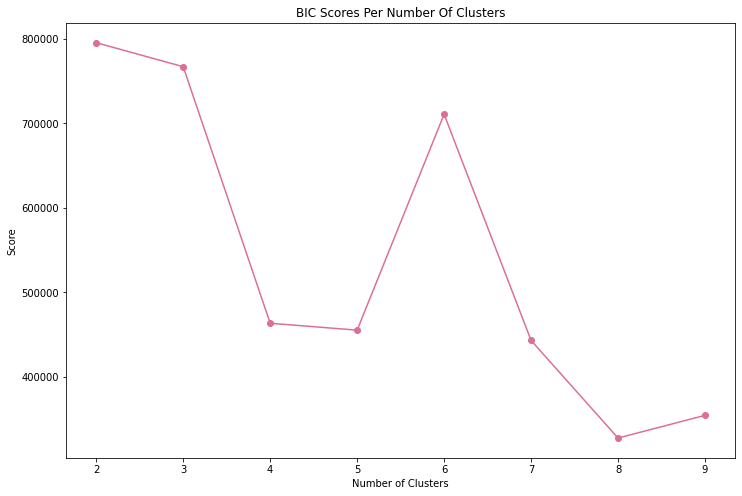

In [4]:
# Plot the BIC and AIC values together
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(12, 8), nrows=1)
ax.plot(n_range, bic_score, "-o", color="palevioletred")
ax.set(xlabel="Number of Clusters", ylabel="Score")
ax.set_xticks(n_range)
ax.set_title("BIC Scores Per Number Of Clusters")
plt.show()

We try a range of 2-9 clusters because more than that would mean that the clusters lose meaning while also not adding signficantly to lowering the BIC score.


In [5]:
## Smallest BIC score is in 8 clusters
## We fit a model to 8 gaussian clusters

final_gmm = GaussianMixture(
    n_components=8, random_state=4747, covariance_type="spherical"
)
final_gmm.fit(X_norm)
probs = final_gmm.predict_proba(X_norm)

In [6]:
labels = final_gmm.predict(X_norm)

We check that the predicted probabilities give you the likelihood that each song is part of each cluster. It assigns labels based on which label the prediced probability is highest for.

In [7]:
probs[0]

array([7.07625048e-06, 9.68043866e-01, 9.08046014e-03, 1.84108703e-04,
       1.88572709e-06, 2.25338412e-02, 1.48223573e-04, 5.38586367e-07])

In [8]:
labels[0]

1

In [9]:
davies_bouldin_score(X_norm, labels)

1.9997058181383265

In [10]:
silhouette_score(X_norm, labels)

0.09004692066134427

The high DB score and indicates that the clusters with Gaussian are not that far apart or well-dispersed. The lower the DB score (with minimum being 0) the better we have clustered.

There are 4 options for calculating covariances in GMM:
- Full: Each distribution has its own general covariance matrix
- Tied: All distributions share general covariance matrix
- Diag: Each distribution has its own diagonal covariance matrix
- Spherical: Each distribution has its own single variance

In [11]:
## trying other types of covariance metrics
list_of_cov_types = ["tied", "spherical", "diag", "full"]

db_score = []
sil_score = []
for t in list_of_cov_types:
    gmm = GaussianMixture(n_components=8, random_state=4747, covariance_type=t)
    gmm.fit(X_norm)
    clusters = gmm.predict(X_norm)
    db_score.append(davies_bouldin_score(X_norm, clusters))
    sil_score.append(silhouette_score(X_norm, clusters))

In [12]:
import matplotlib.pyplot as plt

<Figure size 1440x720 with 0 Axes>

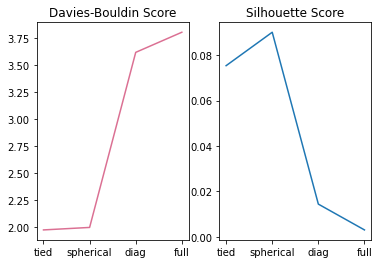

In [13]:
# Plot DB Score and Silhouette Score for each type
plt.figure(figsize=(20, 10))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(
    list_of_cov_types, db_score, label="Davies-Bouldin Score", color="palevioletred"
)
ax1.set_title("Davies-Bouldin Score")
ax2.plot(list_of_cov_types, sil_score, label="Silhouette Score")
ax2.set_title("Silhouette Score")

plt.show()

In [14]:
gaussian_labels = music_X.copy()

In [15]:
gaussian_labels["label"] = labels

In [16]:
gaussian_labels.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label
0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,1
1,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,1
2,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2
3,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,1
4,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,1


In [17]:
gaussian_labels.to_csv("gaussian_cluster.csv")

"The Davies_bouldin score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.
The minimum score is zero, with lower values indicating better clustering."

Our DB is high and silhouette score is close to 0 for gaussian mixture clustering indicating that there is a lot of overlap between clusters. K-means gave us a lower DB score. Let's go back to K-means for now.

In [18]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

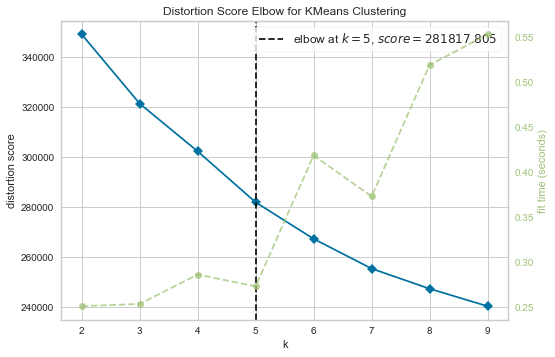

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
k_list = list(range(1, 10))

model = KMeans(random_state=45)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 10), locate_elbow=True)
visualizer.fit(X_norm)  # Fit the data to the visualizer
visualizer.show()

In [20]:
kmeans_model = KMeans(n_clusters=5, random_state=4747)
kmeans_model.fit(X_norm)
labels_kmeans = kmeans_model.predict(X_norm)

Finding the Elbow in Inertia vs. K to see what the optimal cluster size is.

In [21]:
davies_bouldin_score(X_norm, labels_kmeans)

2.16598140902256

In [22]:
silhouette_score(X_norm, labels_kmeans)

0.10459795936857771

In [23]:
kmeans_cluster = music_X.copy()
kmeans_cluster["label"] = labels_kmeans
kmeans_cluster.shape

(32833, 13)

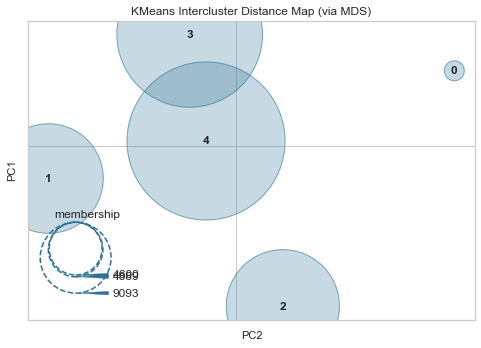

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [24]:
# Inter cluster distance map


from yellowbrick.cluster import InterclusterDistance


# Instantiate the clustering model and visualizer

visualizer = InterclusterDistance(kmeans_model)

visualizer.fit(X_norm)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [25]:
kmeans_cluster.to_csv("kmeans_cluster.csv")

Silhouette Scores:
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

## KMeans vs Gaussian Mixture

Upon exploring the variations in KMeans and Gaussian MM, we see that KMeans performs better than GMM on both scores. The DB Score and silhouette score tell us that in Kmeans our clusters are well-defined. We want to segment and look at clusters that make the most sense.